In [1]:
import subprocess
import sys

print(" Installing timm library for DeiT...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "--quiet"])
print(" Installation complete!")

 Installing timm library for DeiT...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


 Installation complete!


In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Device: {device}")
print(f" GPU tersedia: {torch.cuda.device_count()} unit")

# UPDATED PATH
DATASET_PATH = Path("/kaggle/input/safeface/dataset_clean_384_augmented_safe")
OUTPUT_DIR = Path("/kaggle/working/safeface_deit_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)


 Device: cuda
 GPU tersedia: 2 unit


In [4]:
IMG_SIZE = 384
BATCH_SIZE = 16  # Larger batch = faster + more stable
EPOCHS = 35  # Kurangi epoch (data banyak = cepat converge)
LR_WARMUP = 1e-3
LR_FINETUNE = 3e-6  # Lebih kecil untuk fine-grained learning
WEIGHT_DECAY = 5e-4  # Kurangi regularization (data sudah banyak)
NUM_CLASSES = 70
WARMUP_EPOCHS = 3  # Cukup 3 epoch warmup


In [5]:
def lightweight_preprocessing(image):
    """
    Minimal preprocessing - hanya normalisasi kontras ringan
    Tidak perlu CLAHE agresif karena data sudah di-preprocess
    """
    # Optional: very light CLAHE (bisa skip kalau gambar sudah bagus)
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Clip limit rendah = subtle enhancement
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        image[:,:,0] = clahe.apply(image[:,:,0])
        image[:,:,1] = clahe.apply(image[:,:,1])
        image[:,:,2] = clahe.apply(image[:,:,2])
    return image


In [6]:
class SafeFaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None, use_preprocessing=False):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.use_preprocessing = use_preprocessing

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # Load image
        img = plt.imread(self.paths[idx])
        
        # Handle formats
        if img.shape[-1] == 4:
            img = img[..., :3]
        elif len(img.shape) == 2:
            img = np.stack([img] * 3, axis=-1)
        
        # Convert to uint8
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)
        
        # Minimal preprocessing (optional)
        if self.use_preprocessing:
            img = lightweight_preprocessing(img)
        
        # Transform
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, self.labels[idx]

In [7]:
all_samples = []
classes = sorted([d.name for d in DATASET_PATH.iterdir() if d.is_dir()])

for class_name in classes:
    class_dir = DATASET_PATH / class_name
    for img_path in class_dir.glob("*"):
        if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}:
            all_samples.append((str(img_path), classes.index(class_name)))

paths, labels = zip(*all_samples)
labels = list(labels)

print(f" Total dataset: {len(paths)} gambar dari {len(classes)} kelas")

# Analisis distribusi
class_counts = Counter(labels)
min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
avg_samples = len(paths) / len(classes)

print(f" Sampel per kelas:")
print(f"   Min: {min_samples}")
print(f"   Max: {max_samples}")
print(f"   Avg: {avg_samples:.1f}")
print(f"   Total: {len(paths)}")

 Total dataset: 3613 gambar dari 70 kelas
 Sampel per kelas:
   Min: 39
   Max: 52
   Avg: 51.6
   Total: 3613


In [8]:
print("\n🔪 Splitting dataset...")

# Karena data sudah banyak, bisa pakai stratified split normal
try:
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        paths, labels, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )
    print(" Using stratified split")
except ValueError:
    # Fallback ke manual split kalau masih terlalu sedikit
    print(" Fallback to manual split...")
    train_paths, val_paths = [], []
    train_labels, val_labels = [], []
    
    for class_idx in range(len(classes)):
        class_samples = [(p, l) for p, l in zip(paths, labels) if l == class_idx]
        n_val = max(1, int(len(class_samples) * 0.2))
        np.random.seed(42)
        np.random.shuffle(class_samples)
        
        for i, (p, l) in enumerate(class_samples):
            if i < n_val:
                val_paths.append(p)
                val_labels.append(l)
            else:
                train_paths.append(p)
                train_labels.append(l)

print(f" Train: {len(train_paths)} | Val: {len(val_paths)}")
print(f" Train samples/class: {len(train_paths)/len(classes):.1f}")
print(f" Val samples/class: {len(val_paths)/len(classes):.1f}")


🔪 Splitting dataset...
 Using stratified split
 Train: 2890 | Val: 723
 Train samples/class: 41.3
 Val samples/class: 10.3


In [9]:
print("\n Setup MINIMAL transforms (data already augmented!)...")

# Training: HANYA flip + normalization
# NO rotation, NO color jitter, NO noise!
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),  # Hanya flip karena wajah simetris
    # THAT'S IT! No more augmentation!
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation: Pure evaluation
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print(" Using MINIMAL augmentation strategy:")
print("   - Train: Resize + HorizontalFlip + Normalize")
print("   - Val: Resize + Normalize only")

# Create datasets
train_dataset = SafeFaceDataset(
    train_paths, train_labels, 
    train_transform, 
    use_preprocessing=False  # Skip preprocessing if images already 384x384 clean
)
val_dataset = SafeFaceDataset(
    val_paths, val_labels, 
    val_transform, 
    use_preprocessing=False
)



 Setup MINIMAL transforms (data already augmented!)...
 Using MINIMAL augmentation strategy:
   - Train: Resize + HorizontalFlip + Normalize
   - Val: Resize + Normalize only


In [10]:
print("\n Setup weighted sampler...")
class_weights = {cls: 1.0 / count for cls, count in Counter(train_labels).items()}
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f" Train batches: {len(train_loader)}")
print(f" Val batches: {len(val_loader)}")


 Setup weighted sampler...
 Train batches: 180
 Val batches: 46


In [11]:
print("\n Loading DeiT-Base-384...")

model = timm.create_model('deit_base_patch16_384', pretrained=True, num_classes=0)
print(f" Feature dim: {model.num_features}")

# Custom head (lighter dropout karena data banyak)
model.head = nn.Sequential(
    nn.Dropout(0.3),  # Turun dari 0.5
    nn.Linear(model.num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),  # Turun dari 0.3
    nn.Linear(512, NUM_CLASSES)
)

# Multi-GPU
if torch.cuda.device_count() > 1:
    print(f"🚀 Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)
print(" Model ready!")



 Loading DeiT-Base-384...


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

 Feature dim: 768
🚀 Using 2 GPUs
 Model ready!


In [12]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}', 
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return acc, f1, all_preds, all_labels

In [14]:

print(" STAGE 1: WARMUP (3 epochs)")


# Freeze backbone
if hasattr(model, 'module'):
    for param in model.module.parameters():
        param.requires_grad = False
    for param in model.module.head.parameters():
        param.requires_grad = True
else:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_WARMUP,
    weight_decay=WEIGHT_DECAY
)

best_f1_warmup = 0.0

for epoch in range(WARMUP_EPOCHS):
    print(f"\n Warmup Epoch {epoch+1}/{WARMUP_EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1, _, _ = validate(model, val_loader, device)
    
    print(f"Loss: {train_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc*100:.2f}% | F1: {val_f1:.4f}")
    
    if val_f1 > best_f1_warmup:
        best_f1_warmup = val_f1


 STAGE 1: WARMUP (3 epochs)

 Warmup Epoch 1/3


Validating: 100%|██████████| 46/46 [00:14<00:00,  3.15it/s]


Loss: 2.1002 | Train: 66.70% | Val: 87.69% | F1: 0.8747

 Warmup Epoch 2/3


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 1.1676 | Train: 92.81% | Val: 93.22% | F1: 0.9317

 Warmup Epoch 3/3


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.64it/s]

Loss: 1.0688 | Train: 95.59% | Val: 94.74% | F1: 0.9490


In [15]:

print(" STAGE 2: FINE-TUNING")


# Unfreeze all
for param in model.parameters():
    param.requires_grad = True

# Discriminative LR
if hasattr(model, 'module'):
    backbone_params = [p for n, p in model.module.named_parameters() if 'head' not in n]
    head_params = model.module.head.parameters()
else:
    backbone_params = [p for n, p in model.named_parameters() if 'head' not in n]
    head_params = model.head.parameters()

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': LR_FINETUNE},
    {'params': head_params, 'lr': LR_FINETUNE * 10}
], weight_decay=WEIGHT_DECAY)

# Cosine scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=8,
    T_mult=2,
    eta_min=1e-7
)

best_f1 = 0.0
best_acc = 0.0
patience_counter = 0
patience = 12

history = {
    'train_loss': [], 'train_acc': [],
    'val_acc': [], 'val_f1': []
}

for epoch in range(EPOCHS - WARMUP_EPOCHS):
    print(f"\n Epoch {epoch+1}/{EPOCHS - WARMUP_EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1, _, _ = validate(model, val_loader, device)
    
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc * 100)
    history['val_f1'].append(val_f1)
    
    print(f"Loss: {train_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc*100:.2f}% | F1: {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_acc = val_acc
        patience_counter = 0
        
        save_path = OUTPUT_DIR / "best_model.pth"
        state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': state_dict,
            'val_f1': val_f1,
            'val_acc': val_acc,
        }, save_path)
        print(f" SAVED! Acc: {val_acc*100:.2f}% | F1: {val_f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f" Early stopping at epoch {epoch+1}")
            break

 STAGE 2: FINE-TUNING

 Epoch 1/32


Validating: 100%|██████████| 46/46 [00:16<00:00,  2.77it/s]


Loss: 0.9762 | Train: 98.33% | Val: 98.34% | F1: 0.9836
 SAVED! Acc: 98.34% | F1: 0.9836

 Epoch 2/32


Validating: 100%|██████████| 46/46 [00:16<00:00,  2.73it/s]


Loss: 0.9318 | Train: 99.27% | Val: 98.76% | F1: 0.9876
 SAVED! Acc: 98.76% | F1: 0.9876

 Epoch 3/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.9190 | Train: 99.44% | Val: 98.89% | F1: 0.9889
 SAVED! Acc: 98.89% | F1: 0.9889

 Epoch 4/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Loss: 0.9023 | Train: 99.76% | Val: 98.62% | F1: 0.9861

 Epoch 5/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


Loss: 0.8979 | Train: 99.86% | Val: 99.17% | F1: 0.9918
 SAVED! Acc: 99.17% | F1: 0.9918

 Epoch 6/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 0.8929 | Train: 99.76% | Val: 99.45% | F1: 0.9945
 SAVED! Acc: 99.45% | F1: 0.9945

 Epoch 7/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Loss: 0.8915 | Train: 99.93% | Val: 99.45% | F1: 0.9945
 SAVED! Acc: 99.45% | F1: 0.9945

 Epoch 8/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Loss: 0.8894 | Train: 99.83% | Val: 99.59% | F1: 0.9958
 SAVED! Acc: 99.59% | F1: 0.9958

 Epoch 9/32


Validating: 100%|██████████| 46/46 [00:16<00:00,  2.71it/s]


Loss: 0.8910 | Train: 99.93% | Val: 99.45% | F1: 0.9945

 Epoch 10/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.65it/s]


Loss: 0.8832 | Train: 99.90% | Val: 99.45% | F1: 0.9945

 Epoch 11/32


Validating: 100%|██████████| 46/46 [00:18<00:00,  2.50it/s]


Loss: 0.8773 | Train: 100.00% | Val: 99.72% | F1: 0.9972
 SAVED! Acc: 99.72% | F1: 0.9972

 Epoch 12/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Loss: 0.8736 | Train: 99.86% | Val: 99.59% | F1: 0.9958

 Epoch 13/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8668 | Train: 100.00% | Val: 99.45% | F1: 0.9946

 Epoch 14/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8669 | Train: 99.93% | Val: 99.17% | F1: 0.9919

 Epoch 15/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 0.8654 | Train: 100.00% | Val: 99.31% | F1: 0.9930

 Epoch 16/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 0.8593 | Train: 100.00% | Val: 99.17% | F1: 0.9918

 Epoch 17/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


Loss: 0.8608 | Train: 99.97% | Val: 99.72% | F1: 0.9973
 SAVED! Acc: 99.72% | F1: 0.9973

 Epoch 18/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 0.8586 | Train: 100.00% | Val: 99.45% | F1: 0.9945

 Epoch 19/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Loss: 0.8551 | Train: 99.97% | Val: 99.72% | F1: 0.9973

 Epoch 20/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8539 | Train: 99.97% | Val: 99.72% | F1: 0.9973

 Epoch 21/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Loss: 0.8540 | Train: 99.93% | Val: 99.86% | F1: 0.9986
 SAVED! Acc: 99.86% | F1: 0.9986

 Epoch 22/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8524 | Train: 100.00% | Val: 99.45% | F1: 0.9945

 Epoch 23/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Loss: 0.8517 | Train: 100.00% | Val: 99.45% | F1: 0.9945

 Epoch 24/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.69it/s]


Loss: 0.8522 | Train: 100.00% | Val: 99.72% | F1: 0.9972

 Epoch 25/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]


Loss: 0.8527 | Train: 100.00% | Val: 99.72% | F1: 0.9973

 Epoch 26/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8538 | Train: 100.00% | Val: 99.59% | F1: 0.9959

 Epoch 27/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Loss: 0.8494 | Train: 100.00% | Val: 99.59% | F1: 0.9958

 Epoch 28/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Loss: 0.8461 | Train: 100.00% | Val: 99.31% | F1: 0.9932

 Epoch 29/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Loss: 0.8472 | Train: 99.97% | Val: 99.45% | F1: 0.9946

 Epoch 30/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.63it/s]


Loss: 0.8402 | Train: 100.00% | Val: 99.31% | F1: 0.9931

 Epoch 31/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.64it/s]


Loss: 0.8405 | Train: 100.00% | Val: 99.17% | F1: 0.9917

 Epoch 32/32


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Loss: 0.8368 | Train: 100.00% | Val: 99.86% | F1: 0.9986
 SAVED! Acc: 99.86% | F1: 0.9986



 History plot saved


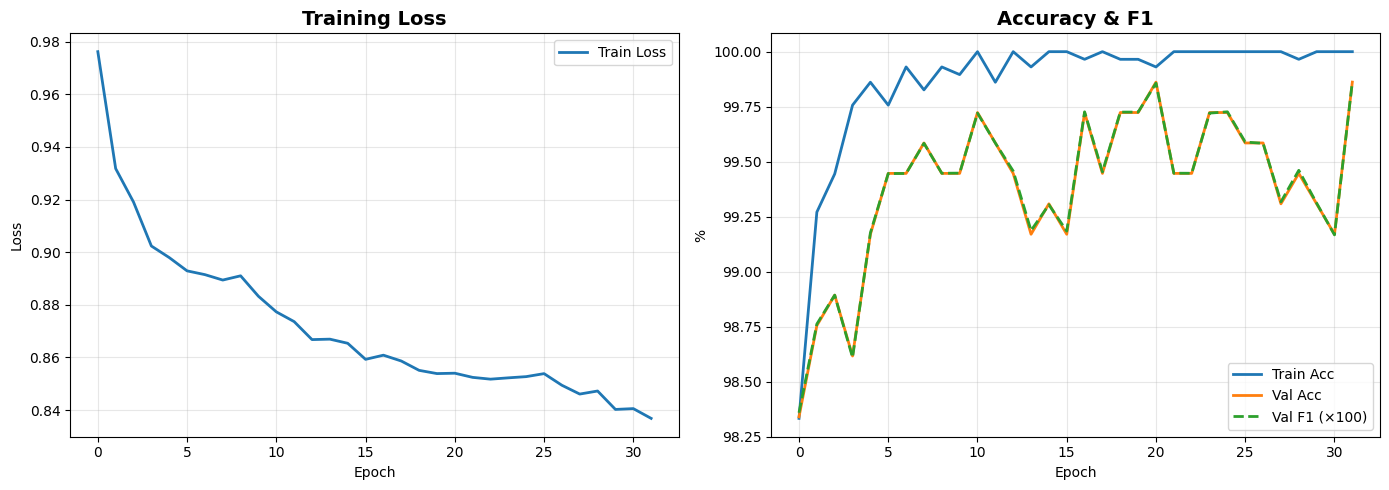

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].plot([f*100 for f in history['val_f1']], label='Val F1 (×100)', linewidth=2, linestyle='--')
axes[1].set_title('Accuracy & F1', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('%')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_history.png", dpi=200)
print(f"\n History plot saved")


In [17]:

print(" FINAL EVALUATION")


try:
    checkpoint = torch.load(OUTPUT_DIR / "best_model.pth", map_location=device, weights_only=False)
except TypeError:
    checkpoint = torch.load(OUTPUT_DIR / "best_model.pth", map_location=device)

if hasattr(model, 'module'):
    model.module.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint['model_state_dict'])

final_acc, final_f1, final_preds, final_labels = validate(model, val_loader, device)


print(" SAFEFACE RESULTS - DeiT")

print(f"Dataset: {len(paths)} images, {len(classes)} classes")
print(f"Avg samples/class: {avg_samples:.1f}")
print(f"Best Val Accuracy: {best_acc*100:.2f}%")
print(f"Best F1-Score: {best_f1:.4f}")


 FINAL EVALUATION


Validating: 100%|██████████| 46/46 [00:17<00:00,  2.67it/s]

 SAFEFACE RESULTS - DeiT
Dataset: 3613 images, 70 classes
Avg samples/class: 51.6
Best Val Accuracy: 99.86%
Best F1-Score: 0.9986


 Confusion matrix saved


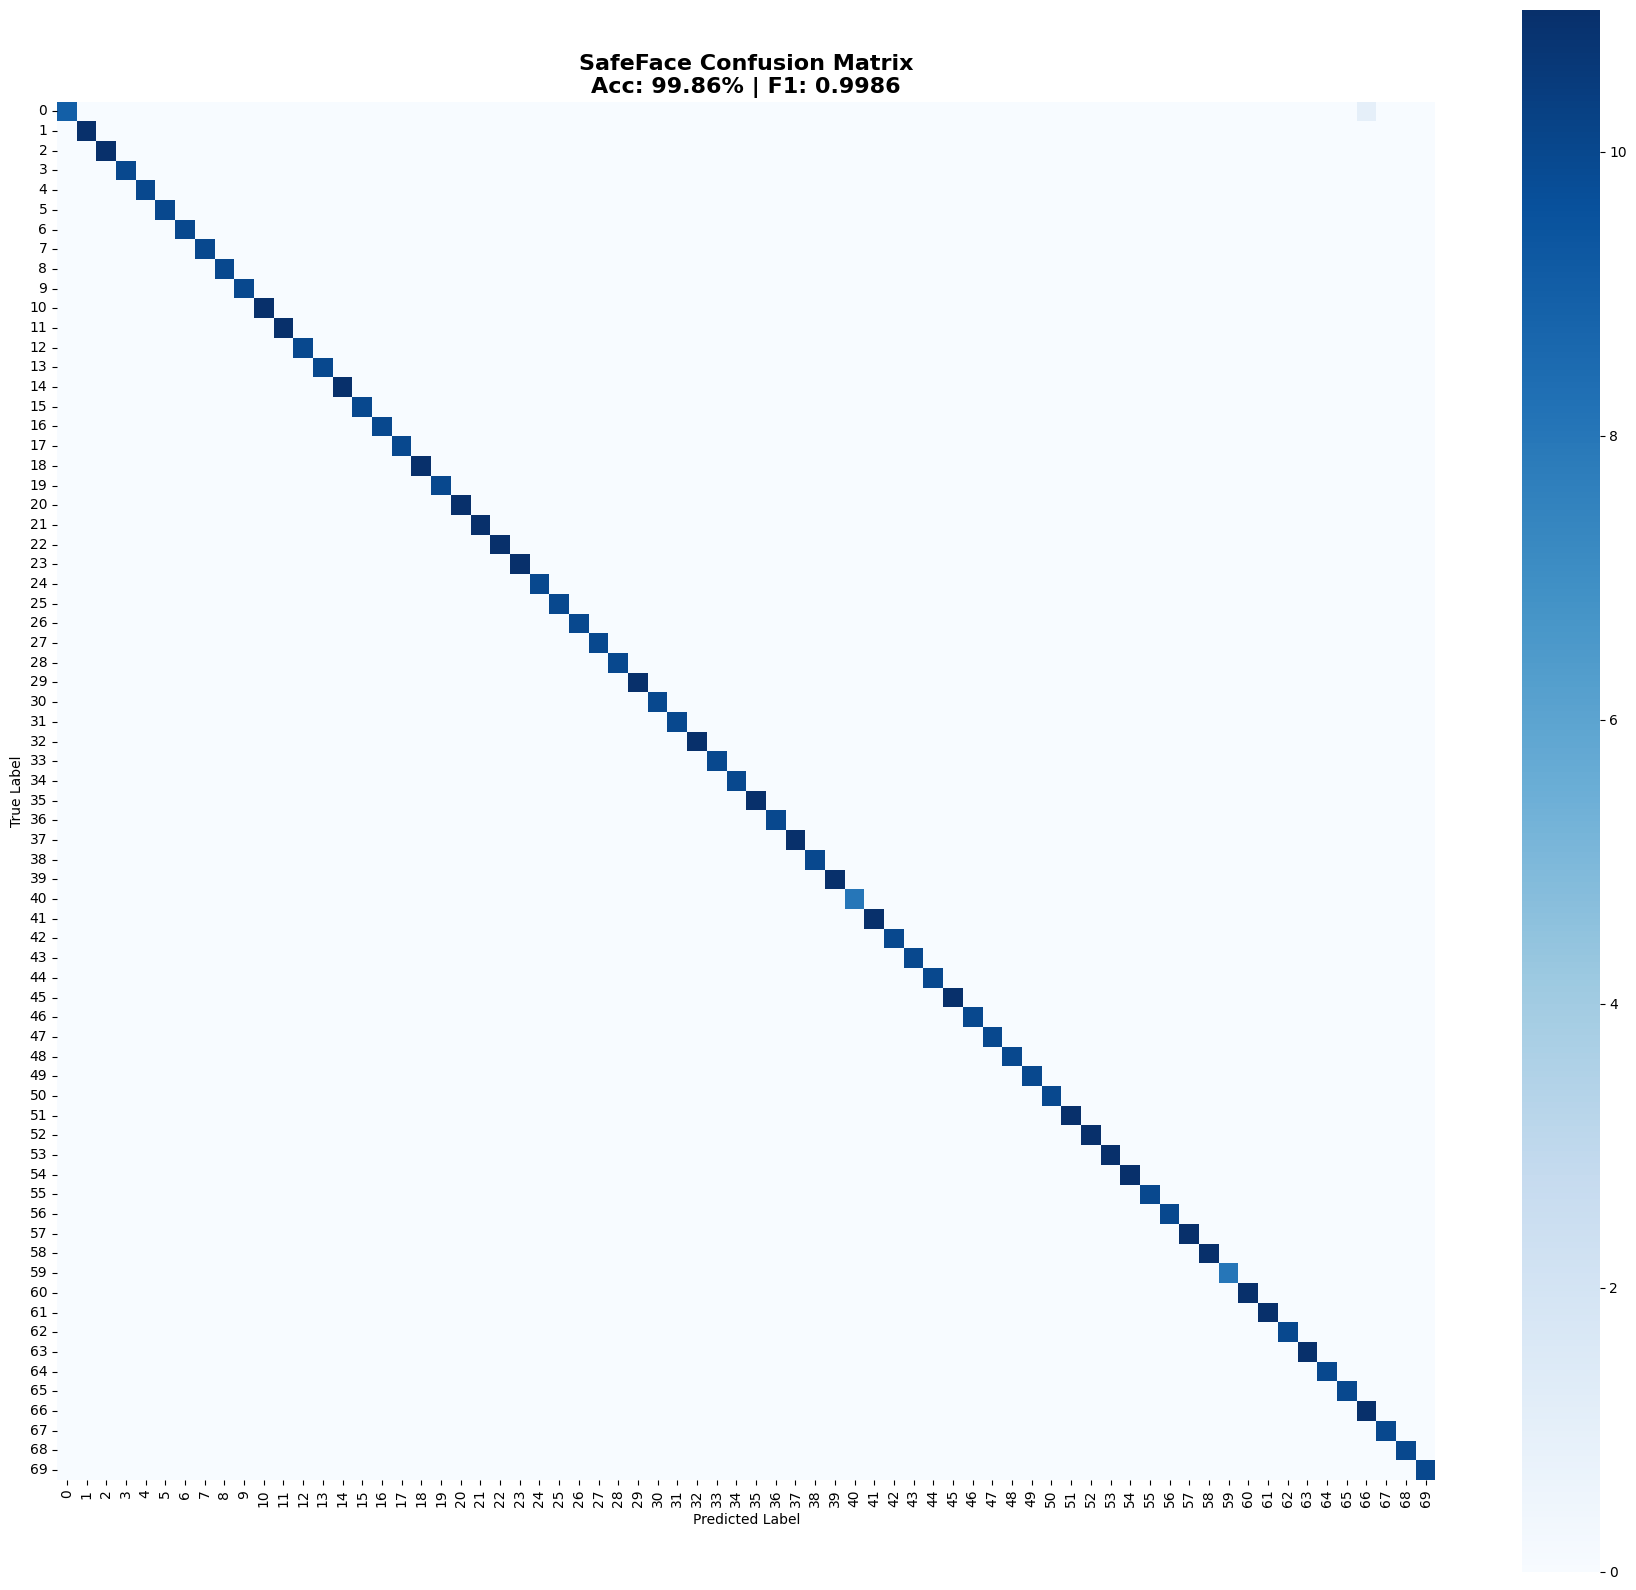

In [18]:
cm = confusion_matrix(final_labels, final_preds)

plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, cmap="Blues", cbar=True, square=True)
plt.title(f"SafeFace Confusion Matrix\nAcc: {final_acc*100:.2f}% | F1: {final_f1:.4f}", 
          fontsize=16, fontweight='bold')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=200)
print(" Confusion matrix saved")


In [19]:
report = classification_report(
    final_labels, final_preds, 
    target_names=classes, 
    output_dict=True,
    zero_division=0
)
pd.DataFrame(report).transpose().to_csv(OUTPUT_DIR / "classification_report.csv")
print("✅ Classification report saved")

# Per-class analysis
class_f1 = {classes[i]: report[classes[i]]['f1-score'] 
            for i in range(len(classes)) if classes[i] in report}

print("\n Top 5 Best Classes:")
for name, score in sorted(class_f1.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {name}: {score:.3f}")

print("\n Top 5 Worst Classes:")
for name, score in sorted(class_f1.items(), key=lambda x: x[1])[:5]:
    print(f"  {name}: {score:.3f}")


✅ Classification report saved

 Top 5 Best Classes:
  Abu Bakar Siddiq Siregar: 1.000
  Ahmad Faqih Hasani: 1.000
  Aldi Sanjaya: 1.000
  Alfajar: 1.000
  Alief Fathur Rahman: 1.000

 Top 5 Worst Classes:
  Abraham Ganda Napitu: 0.947
  Zaky Ahmad Makarim: 0.957
  Abu Bakar Siddiq Siregar: 1.000
  Ahmad Faqih Hasani: 1.000
  Aldi Sanjaya: 1.000
